In [55]:
#importing dependencies
import nbimporter
import Var
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random 
import scipy.optimize
from scipy import stats 
from pandas_datareader import data as pdr
from scipy.stats import norm,binom,chi2
from scipy.linalg import cholesky
import matplotlib.pyplot as plt 
import datetime as dt
import numpy as np
sns.set()

In [56]:
#IMPORTING THE RELEVANT DATA
tickers_list=['AAPL','AMZN','MSFT','GOOG']
start=dt.datetime(2016,1,1)
end=dt.datetime(2019,1,1)
data,returns,dates,meanReturns,covMatrix=Var.getData(tickers_list,start,end)

## Data analysis
### Histogram of the daily returns 
we want to know if the daily stock returns historical data is normal distributed. For this purpose we plot our data and we do different statisticals tests.

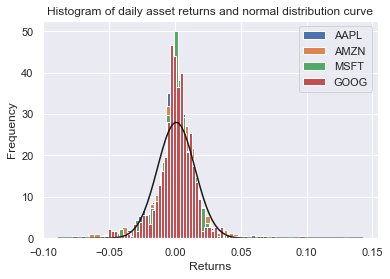

In [58]:
#fitting a normal curve for observation 
mean,std=norm.fit(returns.iloc[:,2])
cols=returns.columns
#plotting the histogram of the data 
plt.hist(returns.iloc[:,0],bins=50,density=True,label=cols[0])
plt.hist(returns.iloc[:,1],bins=50,density=True,label=cols[1])
plt.hist(returns.iloc[:,2],bins=50,density=True,label=cols[2])
plt.hist(returns.iloc[:,3],bins=50,density=True,label=cols[3])
#plot the normal  PDF
xmin,xmax=plt.xlim()
x=np.linspace(xmin,xmax,100)
fittedData=norm.pdf(x,mean,std)
plt.plot(x,fittedData,'k-')
plt.title('Histogram of daily asset returns and normal distribution curve')
plt.ylabel('Frequency')
plt.xlabel('Returns')
plt.legend()



### Calculating the percentage of data within one,two and three std and beyond 5 for a random normal data and our data

In [59]:
np.random.seed(2802)
one_std=[]
two_std=[]
three_std=[]
five_std_plus=[]
row,col=returns.shape
norm_data=np.random.normal(0, 1, len(returns))
mean=np.mean(norm_data)
std=np.std(norm_data)

def std_prop(mean,std):
    """ function that calculates the percentage
    of data within 1,2,3 and >5 sd"""

    one=((norm.cdf(std, mean,std) - norm.cdf(-std, mean,std))*100)
    two=((norm.cdf(2*std, mean,std) - norm.cdf(-2*std, mean,std))*100)
    three=((norm.cdf(3*std, mean,std) - norm.cdf(-3 *std, mean,std))*100)
    five=((1-(norm.cdf(5*std, mean,std) - norm.cdf(-5 *std, mean,std)))*100)
    return one,two,three,five

one,two,three,five=std_prop(mean,std)
one_std.append(one)
two_std.append(two)
three_std.append(three)
five_std_plus.append(five)

for i in range(col):
    mean,std=norm.fit(returns.iloc[:,i])
    one,two,three,five=std_prop(mean,std)
    one_std.append(one)
    two_std.append(two)
    three_std.append(three)
    five_std_plus.append(five)


In [60]:
index=list(returns.columns)
index.insert(0,'NORMAL')
table=pd.DataFrame(list(zip(one_std,two_std,three_std, five_std_plus )),\
                   columns = ['% data within 1-std', '% data within 2-std','% data within 3-std','% data > 5 std'],\
                   index=index)
table

,% data within 1-std,% data within 2-std,% data within 3-std,% data > 5 std
NORMAL,68.266219,95.448755,99.729870,0.000057
AAPL,68.223402,95.429638,99.727515,0.000059
AMZN,68.147656,95.395777,99.723333,0.000061
MSFT,68.167579,95.404689,99.724435,0.000060
GOOG,68.231791,95.433385,99.727977,0.000058


### Q_Q plots or Quantile-Quantile plots


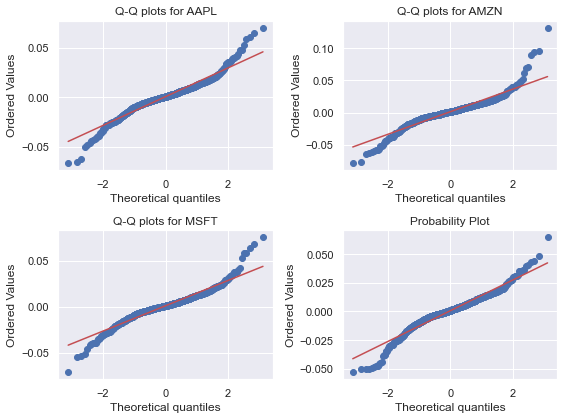

In [61]:
cols=returns.columns
plt.figure(figsize=(8,6))
plt.subplot(221)
stats.probplot(returns.iloc[:,0], dist='norm',plot=plt);
plt.title('Q-Q plots for {}'.format(cols[0]))
plt.subplot(222)
stats.probplot(returns.iloc[:,1], dist='norm',plot=plt);
plt.title('Q-Q plots for {}'.format(cols[1]))
plt.subplot(223)
stats.probplot(returns.iloc[:,2], dist='norm',plot=plt);
plt.title('Q-Q plots for {}'.format(cols[2]))
plt.subplot(224)
plt.title('Q-Q plots for {}'.format(cols[3]))
stats.probplot(returns.iloc[:,3], dist='norm',plot=plt);
plt.tight_layout()




### Shaphiro-Wilks Test



In [62]:
sig_level=0.05
p_values=[]
acceptance=[]

def ShaphiroTest(data,sig_level):
    stat,p_value=stats.shapiro(data)
    return p_value

# storing the p-values of the test
for i in range(col):
    p_value=ShaphiroTest(returns.iloc[:,i],sig_level)
    p_values.append(p_value)
    if p_value>sig_level:
        result=' Fail to reject'
    else:
        result='reject'
    acceptance.append(result)
    

### Analysis of kurtosis and skewness

In [63]:
index=list(returns.columns)
table1=pd.DataFrame(list(zip(stats.kurtosis(returns,axis=0, fisher=True),stats.skew(returns,axis=0),p_values,acceptance)),\
                   columns = ['Kurtosis','skewness', 'p_values of SW test','H0: Normality at {}% CL'.format(sig_level*100)],\
                   index=index)
table1

,Kurtosis,skewness,p_values of SW test,H0: Normality at 5.0% CL
AAPL,3.587451,-0.051424,1.883859e-16,reject
AMZN,7.300626,0.445357,6.472159e-22,reject
MSFT,4.469811,0.070917,9.766517e-18,reject
GOOG,2.777237,-0.445779,2.348166e-15,reject
